In [25]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import zipfile
import os

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/ml_lab/CNN_dataset.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [29]:
base_dir="/content/CNN_dataset"
pictures = []
types = []
categories = ['AbdomenCT', 'CXR', 'ChestCT', 'Hand', 'HeadCT']

In [30]:
for i, category in enumerate(categories):
  category_path = os.path.join(base_dir, category)
  for picture_name in os.listdir(category_path):
      picture_path = os.path.join(category_path, picture_name)
      img = cv2.imread(picture_path)
      img = cv2.resize(img, (64, 64))
      pictures.append(img)
      types.append(i)

In [31]:
images = np.array(pictures, dtype=np.float32)
images = np.expand_dims(images, axis=-1)
labels = np.array(types, dtype=np.int32)

In [32]:
x_train, x_test, y_train, y_test = train_test_split(
    pictures,types,test_size=0.20, stratify=types, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1/0.6,
    stratify=y_train, random_state=35)

In [33]:
x_train = np.array(x_train, dtype='float32') / 255.0
x_val = np.array(x_val, dtype='float32') / 255.0
x_test = np.array(x_test, dtype='float32') / 255.0


In [34]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, AvgPool2D
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [35]:
model = tf.keras.Sequential()
model.add(Conv2D(filters=64, kernel_size=(2,2),strides=(1, 1), padding='same', activation='relu', input_shape=(64,64,3))) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(filters=32, kernel_size=(2,2),strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(filters=64, kernel_size=(2,2),strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        832       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        8224      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)       

In [36]:
x_train = x_train.reshape(-1,64, 64,3)
x_test = x_test.reshape(-1,64, 64, 3)
x_train.shape

(33333, 64, 64, 3)

In [37]:
y_train = np.array(y_train)

model_log=model.fit(x_train, y_train,
          batch_size=60,
          epochs=5,
          verbose=1,
          validation_split=.3)


Epoch 1/5
389/389 [==============================] - 258s 660ms/step - loss: 0.1380 - accuracy: 0.9572 - val_loss: 0.0549 - val_accuracy: 0.9949
Epoch 2/5
389/389 [==============================] - 236s 607ms/step - loss: 0.0203 - accuracy: 0.9944 - val_loss: 0.0134 - val_accuracy: 0.9968
Epoch 3/5
389/389 [==============================] - 232s 596ms/step - loss: 0.0198 - accuracy: 0.9941 - val_loss: 0.0153 - val_accuracy: 0.9963
Epoch 4/5
389/389 [==============================] - 234s 600ms/step - loss: 0.0094 - accuracy: 0.9976 - val_loss: 0.0111 - val_accuracy: 0.9967
Epoch 5/5
389/389 [==============================] - 230s 592ms/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.0075 - val_accuracy: 0.9980


In [38]:
y_test = np.array(y_test)
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9983999729156494


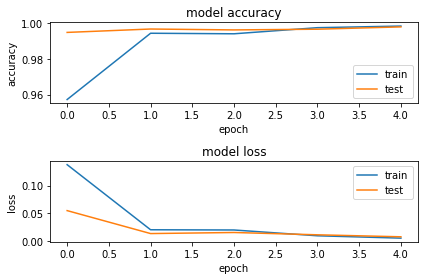

In [39]:
import os
import matplotlib.pyplot as plt
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(model_log.history['accuracy'])
plt.plot(model_log.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()